In [1]:
import torch

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from torch import nn
from torch.autograd.functional import jacobian


torch.manual_seed(0)

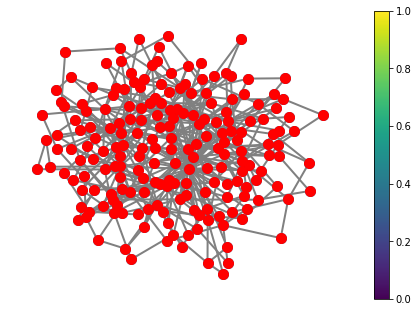

In [2]:
"""
    Effective range
"""
# -- Initialize graph
seed = 32
n_V = 200   # total number of nodes
i = 27      # node ID
k = 6       # k-hop
G = nx.barabasi_albert_graph(n_V, 2, seed=seed)

# -- plot graph
layout = nx.spring_layout(G, seed=seed, iterations=400)
im1 = nx.draw(G, pos=layout, edge_color='gray', width=2, with_labels=False, node_size=100)

# -- plot neighborhood
nodes = nx.single_source_shortest_path_length(G, i, cutoff=k)
im2 = nx.draw_networkx_nodes(G, nodelist=nodes, label=nodes, pos=layout, node_color='red', node_size=100)

# -- visualize
plt.colorbar(im2)
plt.show()
plt.close()

In [3]:
class GCN:
    """
        Graph convolutional layer
    """
    def __init__(self, in_features, out_features):
        # -- initialize weight
        #self.weight = torch.tensor(torch.normal(mean=torch.zeros((in_features,out_features)), std=torch.ones((in_features,out_features))))
        self.weight = nn.Parameter(torch.DoubleTensor(in_features, out_features))
        nn.init.xavier_normal_(self.weight)
        
        # -- non-linearity
        self.f = nn.ReLU()        

    def __call__(self, A, H):
        #degree calculation, sum A and convert each row into a diagonal matrix
        # degree: batch*9*9
        #degree calculation, sum A and convert each row into a diagonal matrix
        #a = torch.sum(A, 1)
        #a = 1./a #inverse
        #b = torch.eye(a.size(1))
        #c = a.unsqueeze(2).expand(*a.size(), a.size(1))
        #degree = c * b
        A += torch.eye(A.shape[0], dtype=torch.float64)
        degree = torch.diag(1. / torch.sqrt(torch.sum(A, axis=1)))
        
        res = torch.matmul(degree, A)
        res = torch.matmul(res, degree)
        res = torch.matmul(res, H.float())
        res = torch.matmul(res, self.weight.float())
        
        return self.f(res)

class MyModel(nn.Module):
    """
        Regression  model
    """
    def __init__(self, A):
        super(MyModel, self).__init__()
        # -- initialize layers
        torch.manual_seed(0)
        self.GCN = GCN(200,100)
        self.A = A
        

    def forward(self, h0):
        h1 = self.GCN(self.A, h0)
        return h1
    
class MyModel2(nn.Module):
    """
        Regression  model
    """
    def __init__(self, A):
        super(MyModel2, self).__init__()
        # -- initialize layers
        torch.manual_seed(0)
        self.GCN1 = GCN(200,100)
        self.GCN2 = GCN(100,50)
        self.GCN3 = GCN(50,20)
        self.A = A
        

    def forward(self, h0):
        h1 = self.GCN1(self.A, h0)
        h2 = self.GCN2(self.A, h1)
        h3 = self.GCN3(self.A, h2)
        return h3
    
class MyModel3(nn.Module):
    """
        Regression  model
    """
    def __init__(self, A):
        super(MyModel3, self).__init__()
        # -- initialize layers
        torch.manual_seed(0)
        self.GCN1 = GCN(200,100)
        self.GCN2 = GCN(100,50)
        self.GCN3 = GCN(50,20)
        self.GCN4 = GCN(20,20)
        self.GCN5 = GCN(20,20)
        self.A = A
        

    def forward(self, h0):
        h1 = self.GCN1(self.A, h0)
        h2 = self.GCN2(self.A, h1)
        h3 = self.GCN3(self.A, h2)
        h4 = self.GCN4(self.A, h3)
        h5 = self.GCN5(self.A, h4)
        return h5
    
    

In [4]:

"""
    Effective range
"""
# -- Initialize graph
seed = 32
n_V = 200   # total number of nodes
i = 17      # node ID
k = 0       # k-hop
G = nx.barabasi_albert_graph(n_V, 2, seed=seed)


A = nx.adjacency_matrix(G)

#A = A.todense()
#A = torch.tensor(A)
#A = A.float()

In [5]:
A = torch.from_numpy(A.toarray())
A = A.float()

In [6]:
node = torch.tensor(list(G.nodes()))
#F.one_hot(x, num_classes=6)
h0 = nn.functional.one_hot(node, num_classes=len(node))
H = h0.float()

print(H.type())

torch.FloatTensor


In [7]:
H_set = []
jacobians = []

def get_jaco(model, H1):
    h = model.forward(H1)
    jaco = jacobian(model,H1)
    return h, jaco

#model1 = MyModel(A)

#print(get_jaco(MyModel(A), H))
h1, jaco1 = get_jaco(MyModel(A), H)
h2, jaco2 = get_jaco(MyModel2(A), H)
h3, jaco3 = get_jaco(MyModel3(A), H)

In [14]:
inf = []
for i in [27]:
    for j in range(200):
        test = jaco1[i,:,j]
        inf.append(torch.sum(test))
        
    for j in range(200):
        test = jaco2[i,:,j]
        inf.append(torch.sum(test))
        
    for j in range(200):
        test = jaco3[i,:,j]
        inf.append(torch.sum(test))
    

In [15]:
res = torch.rand(600)

for i, item in enumerate(inf):
    res[i] = item
    
print(res.shape)

torch.Size([600])


In [21]:
print(res[400:600])

tensor([-5.0346e-03, -5.4391e-03,  1.6439e-03, -1.2402e-01, -3.5207e-03,
         3.1755e-04,  5.8441e-03,  2.1004e-04,  1.3670e-03, -6.8068e-05,
        -3.6575e-05,  3.2400e-04,  6.2008e-05,  1.9331e-05,  3.7301e-04,
        -1.2180e-01,  4.1209e-04,  3.0975e-03,  3.0098e-04, -5.7075e-05,
        -3.9381e-02, -9.5978e-05,  3.2399e-05,  6.5210e-04,  3.5840e-03,
         9.0634e-04,  4.7452e-05, -7.7869e-01, -5.7037e-03,  2.2913e-04,
        -1.5755e-03,  5.2308e-04,  3.9300e-04,  2.8776e-04, -3.1955e-01,
         5.1530e-05,  4.4392e-04, -7.6705e-05,  7.5362e-06,  1.0242e-05,
         1.5652e-03, -1.0742e-05,  1.1736e-05, -6.0533e-06, -1.2826e-02,
         1.2252e-03,  5.5002e-07,  3.2603e-04,  7.3903e-04,  2.5162e-06,
        -6.2881e-07, -3.4018e-02, -3.6794e-04,  4.5798e-05,  2.9678e-04,
        -2.2050e-02,  7.6615e-05,  1.5582e-04,  4.0775e-05,  4.1172e-05,
         4.4711e-04,  2.5830e-04,  4.2913e-03,  1.2301e-04,  2.2191e-06,
         5.0011e-07,  1.6063e-05,  1.1393e-03,  5.3

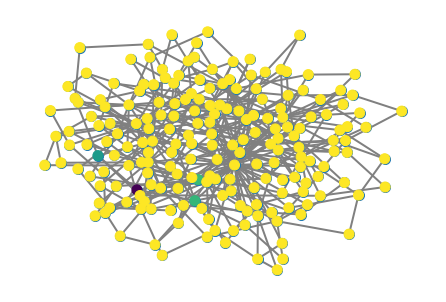

In [17]:

G = nx.barabasi_albert_graph(n_V, 2, seed=seed)
layout = nx.spring_layout(G, seed=seed, iterations=400)
nx.draw(G, pos=layout, edge_color='gray', width=2, with_labels=False, node_size=100)
nodes = list(range(200))
im2 = nx.draw_networkx_nodes(G, nodelist=nodes, label=nodes, pos=layout, node_color=res[0:200], node_size=100)

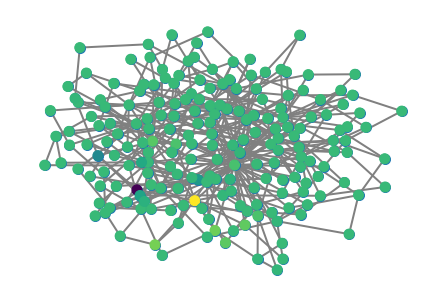

In [18]:

G = nx.barabasi_albert_graph(n_V, 2, seed=seed)
layout = nx.spring_layout(G, seed=seed, iterations=400)
nx.draw(G, pos=layout, edge_color='gray', width=2, with_labels=False, node_size=100)
nodes = list(range(200))
im2 = nx.draw_networkx_nodes(G, nodelist=nodes, label=nodes, pos=layout, node_color=res[200:400], node_size=100)

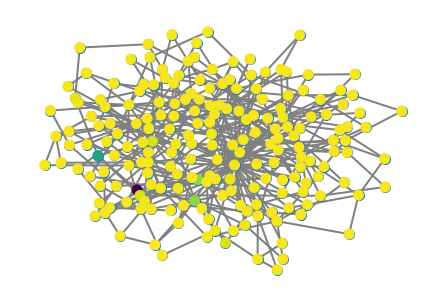

In [19]:

G = nx.barabasi_albert_graph(n_V, 2, seed=seed)
layout = nx.spring_layout(G, seed=seed, iterations=400)
nx.draw(G, pos=layout, edge_color='gray', width=2, with_labels=False, node_size=100)
nodes = list(range(200))
im2 = nx.draw_networkx_nodes(G, nodelist=nodes, label=nodes, pos=layout, node_color=res[400:600], node_size=100)